Spark Assignment #1 : RDD Operations

Author: Tryambak Kaushik

In [1]:
import findspark
import datetime
findspark.init()
from pyspark import SparkContext
sc = SparkContext("local", "first app")
#print(sc)

In [2]:
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from pyspark.sql.types import DateType, IntegerType
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

sqlContext = SQLContext(sc)

In [3]:
MYDIR='/user/hdfs/sparkdata'

In [4]:
%%bash -s "$MYDIR"

if ! hdfs dfs -test -e $1 ; then 
echo "Creating $1 on HDFS"
hadoop fs -mkdir $1
fi

hadoop fs -find / -name $1

echo "Transfering files from local file system to hadoop file system"
for file in /var/lib/hadoop-hdfs/datauniversity/spark/orders/*.csv
do
 hadoop fs -put $file $1
done

hadoop fs -ls $1

Transfering files from local file system to hadoop file system
Found 8 items
-rw-r--r--   1 cloudera supergroup      16745 2020-05-31 09:33 /user/hdfs/sparkdata/customers.csv
-rw-r--r--   1 cloudera supergroup       2025 2020-05-31 09:33 /user/hdfs/sparkdata/employees.csv
-rw-r--r--   1 cloudera supergroup        628 2020-05-31 09:33 /user/hdfs/sparkdata/offices.csv
-rw-r--r--   1 cloudera supergroup     109989 2020-05-31 09:33 /user/hdfs/sparkdata/orderdetails.csv
-rw-r--r--   1 cloudera supergroup      28018 2020-05-31 09:26 /user/hdfs/sparkdata/orders.csv
-rw-r--r--   1 cloudera supergroup      11132 2020-05-31 09:33 /user/hdfs/sparkdata/payments.csv
-rw-r--r--   1 cloudera supergroup       3438 2020-05-31 09:33 /user/hdfs/sparkdata/productlines.csv
-rw-r--r--   1 cloudera supergroup      31013 2020-05-31 09:34 /user/hdfs/sparkdata/products.csv


put: `/user/hdfs/sparkdata/orders.csv': File exists


In [5]:
# Read file for HDFS
orders=sc.textFile("hdfs://quickstart.cloudera:8020"+MYDIR+"/orders.csv")
orderdetails=sc.textFile("hdfs://quickstart.cloudera:8020"+MYDIR+"/orderdetails.csv")
payments=sc.textFile("hdfs://quickstart.cloudera:8020"+MYDIR+"/payments.csv")

In [6]:
ordersrdd=orders.map(lambda line: (line.split('|')[0].strip('"'), 
                                   line.split('|')[1].strip('"'),
                                   line.split('|')[2].strip('"'),
                                   line.split('|')[3].strip('"'), 
                                   line.split('|')[4].strip('"'),
                                   line.split('|')[5].strip('"'),
                                   line.split('|')[6].strip('"'))).collect()
print(ordersrdd[0][1])

2003-01-06


In [7]:
orderdetailsrdd=orderdetails.map(lambda line: (line.split('|')[0].strip('"'), 
                                               line.split('|')[1].strip('"'),
                                               line.split('|')[2].strip('"'), 
                                               line.split('|')[3].strip('"'),
                                               line.split('|')[4].strip('"'))).collect()
print(orderdetailsrdd[0][0])

10100


In [8]:
paymentsrdd=payments.map(lambda line: (line.split('|')[0].strip('"'), 
                                               line.split('|')[1].strip('"'),
                                               line.split('|')[2].strip('"'), 
                                               line.split('|')[3].strip('"'))).collect()
print(paymentsrdd[0][0])

103


In [9]:
df_orders=sqlContext.createDataFrame(ordersrdd, schema=['orderNumber', 'orderDate', 
                                                        'requiredDate', 'shippedDate', 
                                                        'status', 'comments', 
                                                        'customerNumber'])
df_orders.show(2)

+-----------+----------+------------+-----------+-------+--------------------+--------------+
|orderNumber| orderDate|requiredDate|shippedDate| status|            comments|customerNumber|
+-----------+----------+------------+-----------+-------+--------------------+--------------+
|      10100|2003-01-06|  2003-01-13| 2003-01-10|Shipped|                  \N|           363|
|      10101|2003-01-09|  2003-01-18| 2003-01-11|Shipped|Check on availabi...|           128|
+-----------+----------+------------+-----------+-------+--------------------+--------------+
only showing top 2 rows



In [10]:
df_orderdetails=sqlContext.createDataFrame(orderdetailsrdd, 
                                           schema=['orderNumber', 'productCode', 
                                                   'quantityOrdered', 'priceEach', 
                                                   'orderLineNumber'])
df_orderdetails.show(2)

+-----------+-----------+---------------+---------+---------------+
|orderNumber|productCode|quantityOrdered|priceEach|orderLineNumber|
+-----------+-----------+---------------+---------+---------------+
|      10100|   S18_1749|             30|   136.00|              3|
|      10100|   S18_2248|             50|    55.09|              2|
+-----------+-----------+---------------+---------+---------------+
only showing top 2 rows



In [11]:
df_payments=sqlContext.createDataFrame(paymentsrdd, 
                                           schema=['customerNumber', 'checkNumber', 
                                                   'paymentDate', 'amount'])
df_payments.show(2)

+--------------+-----------+-----------+--------+
|customerNumber|checkNumber|paymentDate|  amount|
+--------------+-----------+-----------+--------+
|           103|   HQ336336| 2004-10-19| 6066.78|
|           103|   JM555205| 2003-06-05|14571.44|
+--------------+-----------+-----------+--------+
only showing top 2 rows



In [12]:
# Join Dataframes orders and orderdetails
df_join_orders = df_orderdetails.join(df_orders, on='orderNumber')
df_join_orders.show(2)

+-----------+-----------+---------------+---------+---------------+----------+------------+-----------+-------+--------+--------------+
|orderNumber|productCode|quantityOrdered|priceEach|orderLineNumber| orderDate|requiredDate|shippedDate| status|comments|customerNumber|
+-----------+-----------+---------------+---------+---------------+----------+------------+-----------+-------+--------+--------------+
|      10153|   S12_1108|             20|   201.57|             11|2003-09-28|  2003-10-05| 2003-10-03|Shipped|      \N|           141|
|      10153|   S12_3148|             42|   128.42|             12|2003-09-28|  2003-10-05| 2003-10-03|Shipped|      \N|           141|
+-----------+-----------+---------------+---------+---------------+----------+------------+-----------+-------+--------+--------------+
only showing top 2 rows



In [13]:
print(df_join_orders.dtypes)
print(df_join_orders.printSchema())

[('orderNumber', 'string'), ('productCode', 'string'), ('quantityOrdered', 'string'), ('priceEach', 'string'), ('orderLineNumber', 'string'), ('orderDate', 'string'), ('requiredDate', 'string'), ('shippedDate', 'string'), ('status', 'string'), ('comments', 'string'), ('customerNumber', 'string')]
root
 |-- orderNumber: string (nullable = true)
 |-- productCode: string (nullable = true)
 |-- quantityOrdered: string (nullable = true)
 |-- priceEach: string (nullable = true)
 |-- orderLineNumber: string (nullable = true)
 |-- orderDate: string (nullable = true)
 |-- requiredDate: string (nullable = true)
 |-- shippedDate: string (nullable = true)
 |-- status: string (nullable = true)
 |-- comments: string (nullable = true)
 |-- customerNumber: string (nullable = true)

None


In [14]:
# Join Dataframes orders and payments
df_join_payments = df_payments.join(df_orders, on='customerNumber')
df_join_payments.show(2)

+--------------+-----------+-----------+--------+-----------+----------+------------+-----------+-------+--------------------+
|customerNumber|checkNumber|paymentDate|  amount|orderNumber| orderDate|requiredDate|shippedDate| status|            comments|
+--------------+-----------+-----------+--------+-----------+----------+------------+-----------+-------+--------------------+
|           286|   DR578578| 2004-10-28|47411.33|      10285|2004-08-27|  2004-09-04| 2004-08-31|Shipped|                  \N|
|           286|   DR578578| 2004-10-28|47411.33|      10305|2004-10-13|  2004-10-22| 2004-10-15|Shipped|Check on availabi...|
+--------------+-----------+-----------+--------+-----------+----------+------------+-----------+-------+--------------------+
only showing top 2 rows



In [15]:
#1. Find customer(s) who have ordered more that 10 times
print("1. Find customer(s) who have ordered more that 10 times\n")
print("The customers who have ordered more than 10 items:")
df_group=df_join_orders.groupBy('customerNumber').agg(
    {'productCode': 'count'})
df_group=df_group.filter(df_group['count(productCode)']>10).orderBy('count(productCode)')
print(df_group.show(5))
print("".join([str(df_group.toPandas().count()[0]), " customers have ordered more than 10 items"]))

1. Find customer(s) who have ordered more that 10 times

The customers who have ordered more than 10 items:
+--------------+------------------+
|customerNumber|count(productCode)|
+--------------+------------------+
|           173|                11|
|           489|                12|
|           475|                13|
|           344|                13|
|           347|                14|
+--------------+------------------+
only showing top 5 rows

None
92 customers have ordered more than 10 items


In [16]:
#2. Find the orderDate of the 'In Process' order for customerNumber 124
print("2. Find the orderDate of the 'In Process' order for customerNumber 124\n")
df_filter=df_join_orders.filter(df_join_orders.status == 'In Process').filter(df_join_orders.customerNumber==124)

print(df_filter.select('customerNumber', 'orderDate', 'status').show())

2. Find the orderDate of the 'In Process' order for customerNumber 124

+--------------+----------+----------+
|customerNumber| orderDate|    status|
+--------------+----------+----------+
|           124|2005-05-29|In Process|
|           124|2005-05-29|In Process|
+--------------+----------+----------+

None


In [17]:
#3. What is the total payment made (all orders) by customerNumber 124?
print('3. What is the total payment made (all orders) by customerNumber 124?\n')

df_filter=df_join_orders.filter(df_join_orders.customerNumber==124)
print(df_filter.select("customerNumber", "quantityOrdered", "priceEach").show(5))
df_filter=df_join_orders.filter(df_join_orders.customerNumber==124).withColumn(
    "result", round(col("quantityOrdered") * col("priceEach"),2) ).groupBy().sum("result").collect()[0]["sum(result)"]
print("".join(("The total payment made by customerNumber 124 = ", str(df_filter))))

3. What is the total payment made (all orders) by customerNumber 124?

+--------------+---------------+---------+
|customerNumber|quantityOrdered|priceEach|
+--------------+---------------+---------+
|           124|             34|   166.24|
|           124|             37|   145.04|
|           124|             34|   143.61|
|           124|             32|   103.10|
|           124|             25|   160.46|
+--------------+---------------+---------+
only showing top 5 rows

None
The total payment made by customerNumber 124 = 591827.34


In [18]:
#4. Which customer has the highest amount for one order?
print("4. Which customer has the highest amount for one order?\n")
df_filter=df_join_orders.withColumn("quantityOrdered",col(
    "quantityOrdered").cast("float")).groupby('customerNumber','productCode').sum("quantityOrdered")
df_filter=df_filter.sort(desc("sum(quantityOrdered)")).limit(1)
print(df_filter.show())
print( "".join([df_filter.select("customerNumber").rdd.flatMap(
    lambda x: x).collect()[0], " has the highest amount (", str(
    df_filter.toPandas()['sum(quantityOrdered)'][0]), ") for one order"]))

4. Which customer has the highest amount for one order?

+--------------+-----------+--------------------+
|customerNumber|productCode|sum(quantityOrdered)|
+--------------+-----------+--------------------+
|           141|   S18_3232|               308.0|
+--------------+-----------+--------------------+

None
141 has the highest amount (308.0) for one order


In [19]:
# 5. Create a list of - customerNumber, orderDate, paymentDate of orders places in 2013
print("5. Create a list of - customerNumber, orderDate, paymentDate of orders places in 2013\n")
print("The output list is:")
df_filter=df_join_payments.filter(year("paymentDate")==2013).select("customerNumber", "orderDate", "paymentDate")
print(df_filter.show())

print("\nAll payment data in descending order")
df_join_payments.select("customerNumber", "orderDate", "paymentDate").sort(desc("paymentDate")).show(5)

print("No paymentDate of orders was placed in 2013")

5. Create a list of - customerNumber, orderDate, paymentDate of orders places in 2013

The output list is:
+--------------+---------+-----------+
|customerNumber|orderDate|paymentDate|
+--------------+---------+-----------+
+--------------+---------+-----------+

None

All payment data in descending order
+--------------+----------+-----------+
|customerNumber| orderDate|paymentDate|
+--------------+----------+-----------+
|           353|2004-12-15| 2005-06-09|
|           353|2004-11-24| 2005-06-09|
|           353|2003-07-10| 2005-06-09|
|           353|2003-05-07| 2005-06-09|
|           353|2005-03-30| 2005-06-09|
+--------------+----------+-----------+
only showing top 5 rows

No paymentDate of orders was placed in 2013


In [20]:
# 5. Create a list of - customerNumber, orderDate, paymentDate of orders places in 2013
print("5. Create a list of - customerNumber, orderDate, paymentDate of orders places in 2013\n")
print("The output list is (Alternate attempt-String Comparison):")
df_filter=df_join_payments.filter(df_join_payments.paymentDate.like('2013%')).select("customerNumber", "orderDate", "paymentDate")
print(df_filter.show())

print("\nAll payment data in descending order")
df_join_payments.select("customerNumber", "orderDate", "paymentDate").sort(desc("paymentDate")).show(5)

print("No paymentDate of orders was placed in 2013")

5. Create a list of - customerNumber, orderDate, paymentDate of orders places in 2013

The output list is (Alternate attempt-String Comparison):
+--------------+---------+-----------+
|customerNumber|orderDate|paymentDate|
+--------------+---------+-----------+
+--------------+---------+-----------+

None

All payment data in descending order
+--------------+----------+-----------+
|customerNumber| orderDate|paymentDate|
+--------------+----------+-----------+
|           353|2004-12-15| 2005-06-09|
|           353|2004-11-24| 2005-06-09|
|           353|2003-07-10| 2005-06-09|
|           353|2003-05-07| 2005-06-09|
|           353|2005-03-30| 2005-06-09|
+--------------+----------+-----------+
only showing top 5 rows

No paymentDate of orders was placed in 2013


In [21]:
# 6. Find totals by customers for the top 10 customer
print("6. Find totals by customers for the top 10 customer\n")
print("The top 10 customers by totals are:")
df_filter=df_join_orders.withColumn('result', col("quantityOrdered") * col("priceEach")).groupby(
    'customerNumber').agg(round(sum('result'),2).alias('res')).sort(desc("res")).limit(10)
print(df_filter.show())

6. Find totals by customers for the top 10 customer

The top 10 customers by totals are:
+--------------+---------+
|customerNumber|      res|
+--------------+---------+
|           141|820689.54|
|           124|591827.34|
|           114|180585.07|
|           151|177913.95|
|           119|158573.12|
|           148|156251.03|
|           323|154622.08|
|           131|149085.15|
|           187|148410.09|
|           450|143536.27|
+--------------+---------+

None


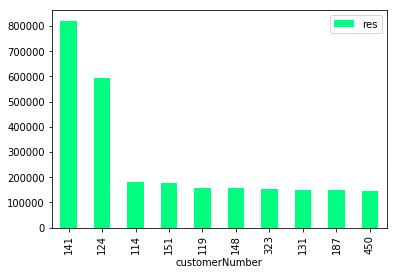

In [22]:
# 7. Plot results on a graph
df_filter_pandas = df_filter.toPandas()
df_filter_pandas.plot(kind='bar',x='customerNumber',y='res',colormap='winter_r')